In [1]:
import numpy as np, matplotlib.pyplot as plt, csv, os, sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
home_path = os.path.abspath(os.getcwd()+"/..")
sys.path.append(home_path)
# from functions import *

In [29]:
def ssim_metric(imageA, imageB):
    """
    The SSIM image quality metric.
    Compares luminosity constrast and structure of two images to
    return a score between 1 (perfectly similar) and 0 (perfectly dissimilar).
    """
    from skimage.metrics import _structural_similarity as ssim
    s = ssim.structural_similarity(imageA, imageB)
    return s

def coord_cleaner(input_string):
    digit_list = []
    for a in input_string.split(","):
        # catch and remove decimal points, '-' signs and line breaks.
        clean_a = a.replace('.', '').replace('\n', '').replace('', '').lstrip("-").isdigit()
        digit_list.append(float(a))
    return tuple(digit_list)


def voltage_cleaner(input_string):
    digit_list = []
    for a in input_string.split(","):
        # catch and remove decimal points, '-' signs and line breaks.
        if a.replace('.', '').replace('\n', '').lstrip("-").isdigit():
            digit_list.append(float(a))
    return digit_list


def csv_file_opener(filename):
    data = []
    with open(filename) as csv_file:
        datafile = csv.reader(csv_file, delimiter=',')
        for row in csv_file:
            data.append(row)
    return data


def coordinate_constructor(coords, scan_type, step_size):

    if scan_type == "xy":
        w = max(coords)[0] - coords[0][0]
        h = max(coords)[1] - coords[0][1]

        xx = np.arange(coords[0][0], coords[0][0] + (w+1), step_size)
        yy = np.arange(coords[0][1], coords[0][1] + (h+1), step_size)
        zz = coords[0][2]

        traversal_coords = []
        for x in xx:
            for y in yy:
                traversal_coords.append((round(x, 2), round(y, 2), round(zz, 2)))

        extents = [coords[0][0], coords[0][0] + (w+1), coords[0][1], coords[0][1] + (h+1)]
        return traversal_coords, w, h, extents

    elif scan_type == "xz":
        w = max(coords)[0] - coords[0][0]
        h = max(coords)[2] - coords[0][2]

        xx = np.arange(coords[0][0], coords[0][0] + (w+1), step_size)
        yy = coords[0][1]
        zz = np.arange(coords[0][2], coords[0][2] + (h+1), step_size)

        traversal_coords = []
        for x in xx:
            for z in zz:
                traversal_coords.append((round(x, 2), round(yy, 2), round(z, 2)))

        extents = [coords[0][0], coords[0][0] + (w+1), coords[0][2], coords[0][2] + (h+1)]
        return traversal_coords, w, h, extents

    elif scan_type == "yz":
        w = max(coords)[1] - coords[0][1]
        h = max(coords)[2] - coords[0][2]

        xx = coords[0][0]
        yy = np.arange(coords[0][1], coords[0][1] + (w+1), step_size)
        zz = np.arange(coords[0][2], coords[0][2] + (h+1), step_size)

        traversal_coords = []
        for y in yy:
            for z in zz:
                traversal_coords.append((round(xx, 2), round(y, 2), round(z, 2)))

        extents = [coords[0][1], coords[0][1] + (h+1), coords[0][2], coords[0][2] + (h+1)]
        return traversal_coords, w, h, extents

    else:
        print(scan_type, "is not a valid scan type")
        
    
def pressure_calculator(raw_coords, traversal_coords, voltages, w, h, step_size, V_Pa=3.16/1000):
    pressure_dict, pressure_list = {}, []
    for i, coord in enumerate(raw_coords):
        V_rms = np.sqrt(np.array(voltages[i]).dot(voltages[i])/np.array(voltages[i]).size)
        pressure_dict[coord] = V_rms / V_Pa
    for coord in traversal_coords:
        pressure_list.append(pressure_dict[coord])
    return np.flipud(np.reshape(pressure_list, (int(w/step_size)+2, int(h/step_size)+1)).T)
#     return np.flipud(np.reshape(pressure_list, (int((w/step_size)+step_size),int((h/step_size)+step_size))).T)


def phase_calculator(raw_coords, traversal_coords, voltages, w, h, step_size, sample_period=250):
    phase_dict, phase_list = {}, []
    for i, coord in enumerate(raw_coords):
        V_min = min(voltages[i])
        V_min_time_index = voltages[i].index(V_min)
        phase_dict[coord] = (2*np.pi/sample_period) * np.mod(V_min_time_index-1, sample_period) - np.pi
    for coord in traversal_coords:
        phase_list.append(phase_dict[coord])
    return np.flipud(np.reshape(phase_list, (int(w/step_size)+2, int(h/step_size)+1)).T)

In [3]:
## --------------> !! IMPORTANT !! <-------------- ##

# https://kiptm.ru/images/Production/bruel/table_pdf/microphones_preamps/2017.02/4138.pdf

"""
- When measuring with the beast, it matters what orientation your microphone is in w.r.t the measurement plane.
- The microphone expects to measure a plane parallel to it - any other orientations require a correction,
increasing as the angle approaches 90 degrees.
- In these experiments we (foolishly) measured an orthogonal, rather than parallel plane. Thus, according to the
datasheet, a constant value of ~4.2dB must be subtracted from all the measurements.
"""

microphone_correction_dB = 4.2

In [42]:
## ----> params <----
step_size = 2.14
V_Pa = 1/1000
scan_type = "xz"

filepath = home_path+r"/Acoustic Lenses/Transmissive/experiments/results"
filename = "UCL_Scan DATE_10 6 2022; TIME_13 49"

## ----> flags <----
data_save_flag = True # if true, will save the calculated pressure matrices as .npy files
overwrite_flag = False # if true, will recalculate the .npy files using the raw .csv data
flip_flag = False

# if we have already built a .npy pressure matrix, load it.
if os.path.exists(filepath+"/npy/"+filename+".npy") and overwrite_flag == False:
    complex_pressure_matrix = np.load(filepath+"/npy/"+filename+".npy")
    print("loaded...", filename)

# else, we need to build it from the raw csv data.
else:

    csv_data = csv_file_opener(filepath+"/csv/"+filename+".csv")

    raw_coords, voltages = [], []
    for j in range(len(csv_data[8:])): # line 8 is where the data begins
        if (j % 2) == 0:
            raw_coords.append(coord_cleaner(csv_data[8:][j]))
        else:
            voltages.append(voltage_cleaner(csv_data[8:][j]))

    traversal_coords, w, h, beast_coords = coordinate_constructor(raw_coords, scan_type, step_size)
    abs_pressure_matrix = pressure_calculator(raw_coords, traversal_coords, voltages, w, h, step_size, V_Pa)
    phase_matrix = phase_calculator(raw_coords, traversal_coords, voltages, w, h, step_size, sample_period=250)

    complex_pressure_matrix = abs_pressure_matrix*np.exp(1j*phase_matrix)
    if flip_flag:  # matrix must be flipped as the beast measures backwards...
        np.fliplr(complex_pressure_matrix)
    # convert to SPL
    complex_pressure_matrix_SPL = 20*np.log10(complex_pressure_matrix/20e-6)
    # take off the microphone correction to account for orthogonal beast measurement
    complex_pressure_matrix_SPL = complex_pressure_matrix_SPL - microphone_correction_dB
    # convert back Pascals
    complex_pressure_matrix = (20e-6) * 10**(complex_pressure_matrix_SPL/20)

    # save the pressure matrix as a .npy, so we don't need to recalculate
    if data_save_flag:
        os.makedirs(filepath+"/npy/", exist_ok=True)
        np.save(filepath+"/npy/"+filename+".npy", complex_pressure_matrix)

    # we need to add 1 extra step to w and h cos the Beast is dumb
    print("calculated...", filename) 

loaded... UCL_Scan DATE_10 6 2022; TIME_13 49


extents: [-174.0248, 174.0248, -109.91040000000004, 109.91040000000004] mm


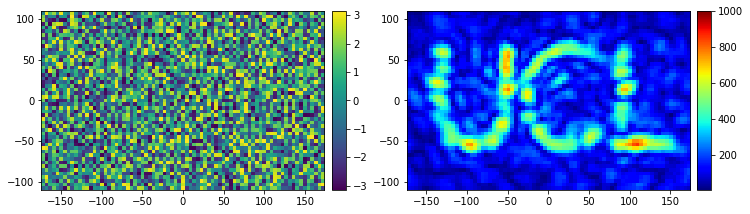

In [43]:
# Plotting params
max_pressure = 1000
extents = [-(w/2)*step_size, (w/2)*step_size, -(h/2)*step_size, (h/2)*step_size]
print("extents:", extents, "mm")

phase_matrix = np.angle(complex_pressure_matrix)
abs_pressure_matrix = abs(complex_pressure_matrix)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# phase (rads)
im1 = ax1.imshow(phase_matrix, vmin=-np.pi, vmax=np.pi, extent=extents)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size='5%', pad=.1)
plt.colorbar(im1, cax=cax)     

# pressure (Pa)
im2 = ax2.imshow(abs_pressure_matrix, vmax=max_pressure, cmap=plt.get_cmap("jet"), extent=extents)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size='5%', pad=.1)
plt.colorbar(im2, cax=cax)

plt.show()